<a href="https://colab.research.google.com/github/holms-ur/CellDetection/blob/main/img2latex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Darknet

In [1]:
%%capture
!git clone https://github.com/AlexeyAB/darknet

In [2]:
%%capture
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

In [3]:
%%capture
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

In [4]:
%%capture
# make darknet (builds darknet so that you can then use the darknet executable file to run or train object detectors)
!make

### Tesseract

In [5]:
%%capture
!sudo apt install tesseract-ocr

In [6]:
%%capture
pip install pytesseract

### Descargar archivos

In [7]:
%%capture
!wget https://www.dropbox.com/s/4spwn7p8cnuorzk/train_last.weights?dl=1 -O train_last.weights

In [8]:
%%capture
!wget https://github.com/holms-ur/CellDetection/releases/download/datasetYOLO/datasetYOLO.zip -O datasetYOLO.zip
!unzip datasetYOLO

In [9]:
!cp datasetYOLO/train.cfg ./cfg

In [10]:
%cd cfg
!sed -i 's/batch=64/batch=1/' train.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' train.cfg
%cd ..

/content/darknet/cfg
/content/darknet


### Librerías y funciones

In [11]:
from pathlib import Path
import json
import os
import numpy as np
from pytesseract import Output
import pytesseract
import argparse

In [12]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def mostrarImagen(imagePath):
  image = cv2.imread(imagePath)
  if len(image.shape)==3:
    img2 = image[:,:,::-1]
    plt.imshow(img2)
    plt.show()
  else:
    img2 = image
    plt.imshow(img2,cmap='gray')
    plt.show()

def mostrarImagenConAnotacion(imagePath,annotationPath,classesPath):
    image = cv2.imread(imagePath)
    (H,W)=image.shape[:2]
    with open(annotationPath) as f:
        lines = f.readlines()
    with open(classesPath) as f:
        clases = f.readlines()
    for annot in lines:
        (c,x,y,w,h) = annot.split(' ')
        cv2.rectangle(image,(int((float(x)-float(w)/2)*W),int((float(y)-float(h)/2)*H)),(int((float(x)+float(w)/2)*W),int((float(y)+float(h)/2)*H)),(0,255,0),10)
        cv2.putText(image,clases[int(c)],(int((float(x)-float(w)/2)*W),int((float(y)-float(h)/2)*H-2)),cv2.FONT_HERSHEY_COMPLEX,0.5,(0,0,0),1)
    img2 = image[:,:,::-1]
    plt.imshow(img2)
    plt.show()


In [13]:
def unconvert(width, height, x, y, w, h):
    xmax = int((x*width) + (w * width)/2.0)
    xmin = int((x*width) - (w * width)/2.0)
    ymax = int((y*height) + (h * height)/2.0)
    ymin = int((y*height) - (h * height)/2.0)
    return (xmin, xmax, ymin, ymax)

In [14]:
def transform(path):
  # config='--psm 6'
  filejson='result.json'
  anotacion=json.loads(open(filejson).read())
  dic_todos=[]
  for archivo in anotacion:
    celdas=[]
    texto=[]
    img=cv2.imread(str(path))
    height,width,_=img.shape
    for objeto in archivo['objects']: 
      # transformación de cada bbox del formato yolo a pascalVOC
      objeto=objeto['relative_coordinates']
      xmin, xmax, ymin, ymax= unconvert(width, height, objeto['center_x'], objeto['center_y'],objeto['width'], objeto['height'])
      if xmin<0:
        xmin=0
      celdas.append([xmin,xmax,ymin,ymax])
      # OCR
      image=img[ymin:ymax,xmin:xmax]
      h,w,_=image.shape
      base_size=h+6,w+6,3
      base=np.zeros(base_size,dtype=np.uint8)
      cv2.rectangle(base,(0,0),(w+6,h+6),(255,255,255),10)
      base[3:h+3,3:w+3]=image
      results = pytesseract.image_to_data(base,output_type=Output.DICT)
      texto.append(' '.join(results['text'][4:]))
    dic={'file':str(path), 'bbox':celdas, 'text':texto}
    dic_todos.append(dic)
  with open('bbox.json', 'w') as outfile:
      json.dump(dic_todos, outfile)

In [15]:
def transformTabla(listDic,filename):
  ncol=max([f['ncol'] for f in listDic])
  columna=filaNCOL(listDic, ncol)
  f = open (filename, "w")
  c='{|'+'|'.join(['c' for i in range(0,ncol)])+'|} \n \hline \n'
  f.write('\\begin{table} \n\\begin{tabular}'+c)
  for dic in listDic:
    f.write(' & '.join(transformFila(dic,columna))+'\\\\ \n \hline \n')
  f.write('\end{tabular} \n\end{table}')
  f.close()

In [16]:
def obtenerFilas(tabla):
  l2=[x[2] for x in tabla['bbox']]
  l2.sort() #los ordenamos
  ant=l2[0]
  i=0
  filas=[[]]
  for x in l2:  #separamos en filas según los ymin. 
    if x< ant+3:
      filas[i].append(x)
    else:
      i+=1
      filas.append([x])
    ant=x
  return filas

In [17]:
def filaNCOL(filas, ncol): #dado el diccionario de filas y un numero de columnas, devuelve las coordenadas 
  for f in filas:           # de una fila con ncol columnas
    if f['ncol']==ncol:
      y=f['x'].copy()
      y.sort()
      return y

In [18]:
def transformFila(dic,columnas): #obtenemos el texto ordenado de dic
  d={dic['x'][i]:dic['text'][i] for i in range(0,len(dic['x']))}
  claves=list(d.keys())
  claves.sort()
  if len(claves)==len(columnas): #si el ncol de la fila es el máximo, no hay combinación de celdas
    return [d[k] for k in claves]
  else: #hay combinación de celdas
    i,j=0,0
    final=[]
    while j<len(columnas) and i<dic['ncol']:
      if claves[i][0]>columnas[j][0]+10: #comparamos los xmin 
        final.append('')
        j+=1
      else: 
        if claves[i][1]<=columnas[j][1]+10: #xmax coinciden
          final.append(d[claves[i]])
          i+=1
          j+=1
        else: #xmax no coinciden
          cont=1
          while j<len(columnas) and claves[i][1]>columnas[j][0]:
            cont+=1
            j+=1
          final.append('\multicolumn{'+str(cont)+'}{c} {'+ d[claves[i]]+'}')
          i+=1
    while j<len(columnas):
      final.append('')
      j+=1
    return final  

In [19]:
def tablas(path):
  path_tablas=Path('tablas')
  if not os.path.isdir(path_tablas):
    %mkdir tablas
  anot=json.loads(open(path).read())
  for tabla in anot:
    filas=obtenerFilas(tabla)
    bbox=tabla['bbox']
    texto=tabla['text']
    ncol=max([len(x) for x in filas]) #buscamos el numero máximo de columnas
    filav2=[x[0]//10 for x in filas]  #nos quedamos con las decenas de los ymin
    xmin=[[] for i in range(0,len(filas))] #una lista por cada fila, almacenamos las coordenadas (xmin,xmax)
    t=[[] for i in range(0,len(filas))] #una lista por cada fila, almacenamos el texto 
    for i in range(0, len(bbox)):
      if bbox[i][2]//10 in filav2:
        t[filav2.index(bbox[i][2]//10)].append(texto[i])
        xmin[filav2.index(bbox[i][2]//10)].append((bbox[i][0]//10,bbox[i][1]//10))
      else: 
        t[filav2.index( bbox[i][2]//10 -1)].append(texto[i])
        xmin[filav2.index(bbox[i][2]//10 -1)].append((bbox[i][0]//10,bbox[i][1]//10))
    #por cada fila creamos un diccionario con las coordenadas, el texto y el número de columnas de dicha fila
    filas=[{'x':xmin[i], 'text':t[i], 'ncol':len(xmin[i])}  for i in range(0,len(xmin))]
    path_file=Path(tabla['file']).stem+'.txt'
    transformTabla(filas, path_tablas/path_file)

In [20]:
def convert(path):
  f = open("file.txt", "w")
  f.write(path)
  f.close()
  !./darknet detector test datasetYOLO/classes.data datasetYOLO/train.cfg train_last.weights -ext_output -dont_show -out result.json < file.txt
  transform(path)
  tablas('bbox.json')

### Ejemplos

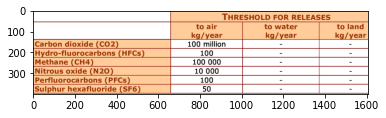

In [22]:
mostrarImagen('datasetYOLO/test/eu-001-1-1.jpg')

In [25]:
convert('datasetYOLO/test/eu-001-1-1.jpg')

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   3 route  1 		                           ->  208 x 208 x  64 
   4 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   8 conv 

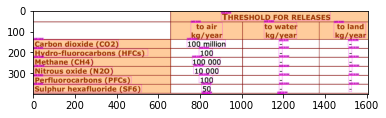

In [24]:
mostrarImagen('predictions.jpg')

In [30]:
f = open('tablas/eu-001-1-1.txt')
print(f.read())

\begin{table} 
\begin{tabular}{|c|c|c|c|} 
 \hline 
 &  & \multicolumn{2}{c} {THRESHOLD FOR RELEASES} & \\ 
 \hline 
 & to air  ka/vear & to water  kaq/vyear & to land  ka/vear\\ 
 \hline 
Carbon dioxide (CO2) & 100 million &  & \\ 
 \hline 
 &  &  & \\ 
 \hline 
Hvdro-fluorocarbons (HFCs) & 100 &  & \\ 
 \hline 
Methane (CH4' & 100 000 &  & \\ 
 \hline 
Nitrous oxide (N20) &      10 O00 &  & \\ 
 \hline 
Perfluorocarbons (PFCs) & 100 &  & \\ 
 \hline 
 &  &  & \\ 
 \hline 
Sulphur hexafluoride (SF6) &  &  & \\ 
 \hline 
 &  &  & \\ 
 \hline 
\end{tabular} 
\end{table}


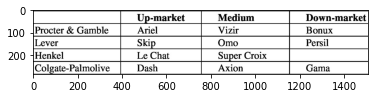

In [26]:
mostrarImagen('datasetYOLO/test/eu-007-1-1.jpg')

In [27]:
convert('datasetYOLO/test/eu-007-1-1.jpg')

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   3 route  1 		                           ->  208 x 208 x  64 
   4 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   8 conv 

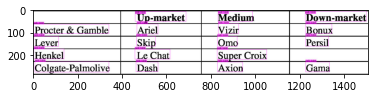

In [28]:
mostrarImagen('predictions.jpg')

In [29]:
f = open('tablas/eu-007-1-1.txt')
print(f.read())

\begin{table} 
\begin{tabular}{|c|c|c|c|} 
 \hline 
 & \multicolumn{2}{c} {Up-market} & Medium & \multicolumn{2}{c} {Down-market}\\ 
 \hline 
Procter & Gamble & Ariel & Vizir & Bonux\\ 
 \hline 
     Lever & Skip & Omo &      Persil\\ 
 \hline 
     Henkel & Le Chat & \multicolumn{2}{c} {Super Croix} & \\ 
 \hline 
Colgate-Palmolive & Dash & Axion & Gama\\ 
 \hline 
\end{tabular} 
\end{table}


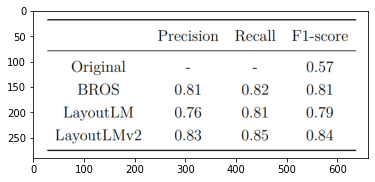

In [ ]:
mostrarImagen('tabla2.PNG')

In [ ]:
convert('tabla2.PNG')

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   3 route  1 		                           ->  208 x 208 x  64 
   4 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   8 conv 

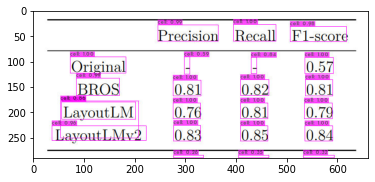

In [ ]:
mostrarImagen('predictions.jpg')

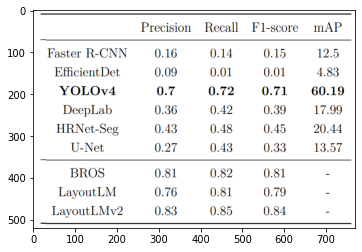

In [ ]:
mostrarImagen('tabla3.PNG')

In [ ]:
convert('tabla3.PNG')

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   3 route  1 		                           ->  208 x 208 x  64 
   4 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   8 conv 

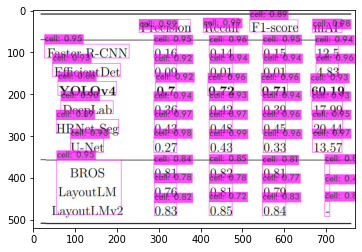

In [ ]:
mostrarImagen('predictions.jpg')

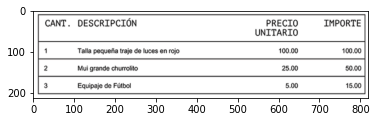

In [ ]:
mostrarImagen('tabla4.PNG')

In [ ]:
convert('tabla4.PNG')

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   3 route  1 		                           ->  208 x 208 x  64 
   4 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   8 conv 

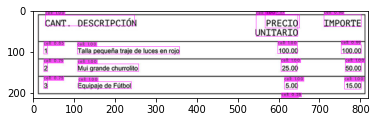

In [ ]:
mostrarImagen('predictions.jpg')


CANT. DESCRTPCTOD | PRECIO  UNITARIO | PRECIO | IMPORTE 
--- | --- |--- |:---: 
1 | Talla pequefia traie de luces en rojo | 100.00 | 100.00 
2 | Mui arande churrolito | 25.00 | 50.00 
3 | Equipaie de Futbol | 5.00 | 15,00 
 |  |  |  


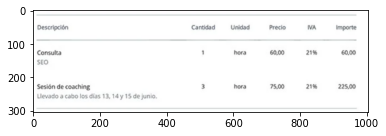

In [ ]:
mostrarImagen('tabla5.PNG')

In [ ]:
convert('tabla5.PNG')

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   3 route  1 		                           ->  208 x 208 x  64 
   4 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   8 conv 

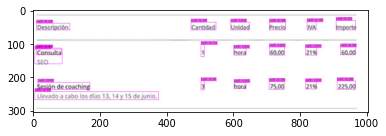

In [ ]:
mostrarImagen('predictions.jpg')

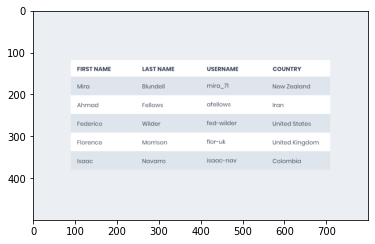

In [ ]:
mostrarImagen('tabla6.png')

In [ ]:
convert('tabla6.png')

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   3 route  1 		                           ->  208 x 208 x  64 
   4 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   8 conv 

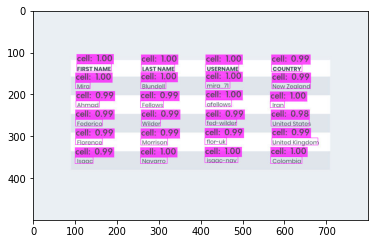

In [ ]:
mostrarImagen('predictions.jpg')


FIRST NAME | LAST NAME | USERNAME | COUNTRY
--- | --- |--- |:---:
Mira | Blundell | mira 71 | New Zealand
Ahmad | Fellows | afellows | tran.
Federico | Wilder | fed-wilder | United State:
Florence | Morrison | flor-uk | United Kinadorr
Isaac | Navarro. | isaac-nav | Colombia



In [ ]:
convert('tabla7.jpg')

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   3 route  1 		                           ->  208 x 208 x  64 
   4 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   8 conv 

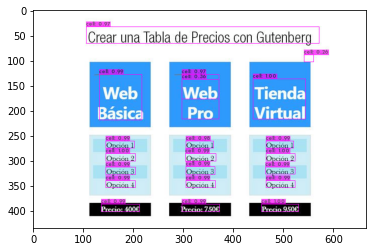

In [ ]:
mostrarImagen('predictions.jpg')